In [1]:
# author: metaquant
# created: 2018-9-14
# blog: https://md.metaquant.org
# GitHub: https://github.com/sorrowise
# repo: https://github.com/sorrowise/chinese_data_analysis

<h2 style="font-family:kaiti">一、引言</h2>

<p style="font-size:16px;font-family:KaiTi;line-height:2">大约八十年前，哈佛大学的语言学家乔治·金斯利·齐普夫(George Kingsley Zipf)对英语中的词频分布进行了研究，发现了一条经验规律，他发现：如果把一篇较长文章中每个词出现的频次统计起来，按照高频词在前、低频词在后的递减顺序排列，并用自然数个这些词编上的等级序号，即频次最高的词等级为1，频次次之的等级为2等等，若用$F$表示频次，$R$表示序号，则有$FR=C$($C$为常数)，也就是说词语的频次和其频次排名呈反比例关系。假如以单词的频次排名为横轴，以单词的频次为纵轴绘制散点图，会发现图形大致呈现双曲线形。为了数学上处理的方便，我们可以对词频及词频排名取对数(自然对数或以十为底的对数均可)，考虑到：$F=\frac{C}{R}$，则有$log(F)=log(C)-log(R)$，所以$log(F)$与$log(R)$呈线性关系，在图形上应该是一条直线，如下：</p>

<img src="https://ws1.sinaimg.cn/large/005LuiSpgy1fv87i85hrpj30zk0qon25.jpg">

<p style="font-size:16px;font-family:KaiTi;line-height:2">受到齐普夫的启发，其它学者也纷纷验证该定律对其它语言的适用性，他们发现齐普夫定律在很多语言中也是成立的。如上图，频次排名对数与频次的对数成线性关系。一个很自然的问题是，该定律在汉语中的适用性如何？</p>

<p style="font-size:16px;font-family:KaiTi;line-height:2">汉字作为象形文字，显著不同于以英语为代表的拼音文字，其语言的基本单位为单字，然后再由单字组成两字词、三字词等以表达更加复杂的意义。拼音文字的基本单位为单词，意义的扩展通过创造新词汇或者拼接已有单词组成新词汇来实现。因此，英语可以以单词为单位来统计词频，而汉语则必须以词语为基本单位来统计，这既包括单字，也包括多字词，只有这样才能准确描述汉语词频的分布规律。</p>

<p style="font-size:16px;font-family:KaiTi;line-height:2">利用教育部语言文字应用研究所计算语言学研究室提供的<a href='http://corpus.zhonghuayuwen.org/Resources.aspx'>在线语料库字词频数据</a>，我们可以检验齐普夫定律在汉语中的适用性，加深我们对汉语词频分布规律的认识。由于以上数据并不包括汉字的笔画数数据，我们可以利用笪骏提供的<a href='http://lingua.mtsu.edu/chinese-computing/statistics/char/list.php?Which=MO'>现代汉语单字频率列表</a>，进一步研究汉字笔画数的分布规律。</p>

<p style="font-size:16px;font-family:KaiTi;line-height:2">我们使用jupyter notebook对以上数据进行分析，相关notebook及数据文件已经上传到<a href='https://github.com/sorrowise/chinese_data_analysis'>这个仓库</a>，大家可以下载数据进行分析验证。数据文件版权归原作者所有，如有侵权请通知我删除。</p>

<h2 style="font-family:kaiti">二、汉语词频分布规律</h2>

<p style="font-size:16px;font-family:KaiTi;line-height:2">首先，我们导入一些数据分析必要的库，并做一些初始化设置：</p>

In [11]:
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
sns.set(style="white",color_codes=True)
import pandas as pd
%matplotlib inline
plt.rcParams['figure.figsize'] = (15,9.27)

<p style="font-size:16px;font-family:KaiTi;line-height:2">然后导入<code>word_freq.xlsx</code>这个数据文件，这个数据文件收录了现代汉语语料库中出现次数大于50次的词的出现次数、频率与累计频率数据。该语料库的规模为2000万字，该表共收集了14629个词，既包括单字，也包括多字词。让我们先看下数据的基本情况：</p>

In [3]:
df = pd.read_excel('word_freq.xlsx')
df.head(10)

,rank,word,freq,freq_percent,cum_freq_percent
0,1,的,744863,7.7946,7.7946
1,2,了,130191,1.3624,9.1570
2,3,在,118823,1.2434,10.4004
3,4,是,118527,1.2403,11.6407
4,5,和,83958,0.8786,12.5193
5,6,一,81119,0.8489,13.3682
6,7,这,65146,0.6817,14.0499
7,8,有,53556,0.5604,14.6103
8,9,他,52912,0.5537,15.1640
9,10,我,52728,0.5518,15.7158


<p style="font-size:16px;font-family:KaiTi;line-height:2">数据的前十行显示如上表：其中第一列为汉字中词语按出现频次从高向低排名，如“的”字在语料库中出现的次数最多，则排在第一名；第二列为对应的汉字及词语；第三列为该汉字或词语在语料库中出现的次数，如“的”在语料库中共出现了744863次；第四列表示该汉字或词语在语料库中出现的频率的百分比，如“的”出现的频率为7.7946%；第五列为累计频率，为该汉字(词语)及排名靠前的汉字(词语)累计出现的频率，如到排名第十的汉字“我”，前十名汉字出现的累计频率为15.7158%。</p>

<p style="font-size:16px;font-family:KaiTi;line-height:2">为了之后分析的方便，我们需要另外计算三列数据，分别为词语频次排名的以10为底的对数、频次以10为底的对数及词语中汉字数(单字词还是多字词)，则：</p>

In [4]:
df['log_rank'] = np.log10(df['rank'])
df['log_freq'] = np.log10(df['freq'])
df['word_count'] = df['word'].apply(len)
df.head(10)

,rank,word,freq,freq_percent,cum_freq_percent,log_rank,log_freq,word_count
0,1,的,744863,7.7946,7.7946,0.000000,5.872076,1
1,2,了,130191,1.3624,9.1570,0.301030,5.114581,1
2,3,在,118823,1.2434,10.4004,0.477121,5.074901,1
3,4,是,118527,1.2403,11.6407,0.602060,5.073817,1
4,5,和,83958,0.8786,12.5193,0.698970,4.924062,1
5,6,一,81119,0.8489,13.3682,0.778151,4.909123,1
6,7,这,65146,0.6817,14.0499,0.845098,4.813888,1
7,8,有,53556,0.5604,14.6103,0.903090,4.728808,1
8,9,他,52912,0.5537,15.1640,0.954243,4.723554,1
9,10,我,52728,0.5518,15.7158,1.000000,4.722041,1


<p style="font-size:16px;font-family:KaiTi;line-height:2">从<code>word_count</code>列，我们可以看到，词频表中收录的最长的词包含十个单字，平均而言包含两个单字。通过简单的统计，我们可以看到词语中汉字个数的分布规律如下表：其中两字词出现的次数最多，为10476次，占比达到71.61%；其次为单字词，为2391次，占比达到16.34%。</p>

In [5]:
# Count the frequency and frequency of occurrences of words of various lengths

word_length = pd.DataFrame(df.word_count.value_counts()).sort_index()
word_length.columns = ['freq']
word_length['freq_percent'] = 100*word_length['freq']/sum(word_length['freq'])
word_length.head(10)

,freq,freq_percent
1,2391,16.344248
2,10476,71.611183
3,1181,8.073006
4,506,3.458883
5,43,0.293937
6,22,0.150386
7,8,0.054686
8,1,0.006836
10,1,0.006836


<p style="font-size:16px;font-family:KaiTi;line-height:2">现在让我们看看汉语中词频的分布规律是否符合齐普夫定律：</p>

Text(0.5,1,'The relationship between the logarithm of the frequency ranking and the logarithm of the frequency')

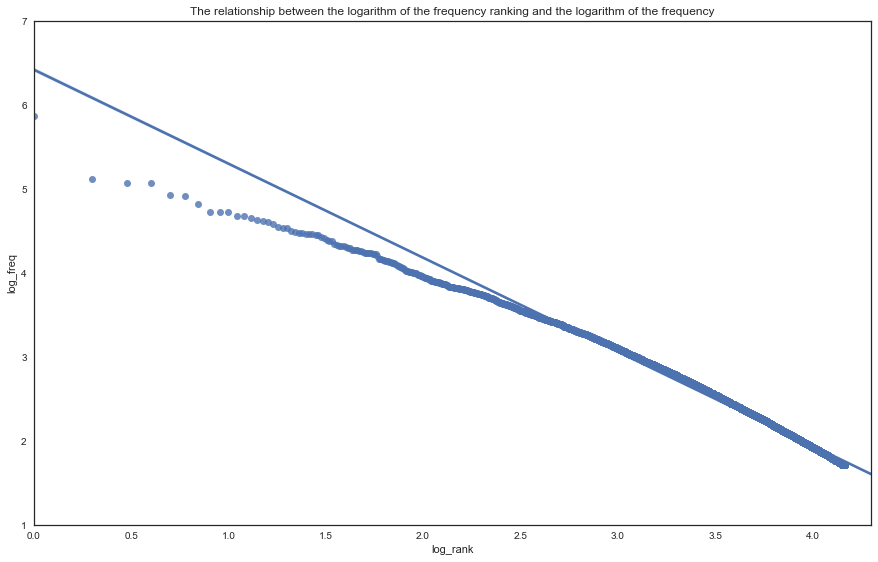

In [6]:
sns.regplot(df.log_rank,df.log_freq)
plt.xlim(0,4.3)
plt.ylim(1,7)
plt.title('The relationship between the logarithm of the frequency ranking and the logarithm of the frequency')

<p style="font-size:16px;font-family:KaiTi;line-height:2;">从上图可以看出，频次排名的对数与频次的关系大致是线性关系，基本符合齐普夫定律。让我们对两个变量做一个线性回归，观察相关指标是否表明两者之间的线性关系足够强。首先，我定义了一个辅助函数，调用statmodels库中的相关函数进行线性回归并返回回归结果。</p>

In [7]:
def reg(y,*args):
    import statsmodels.api as sm
    x = np.vstack((args)).T
    mat_x = sm.add_constant(x)
    res = sm.OLS(y,mat_x).fit()
    print(res.summary())

reg(df.log_rank,df.log_freq)

                            OLS Regression Results                            
Dep. Variable:               log_rank   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                 1.502e+06
Date:                Sat, 15 Sep 2018   Prob (F-statistic):               0.00
Time:                        10:27:07   Log-Likelihood:                 25420.
No. Observations:               14629   AIC:                        -5.084e+04
Df Residuals:                   14627   BIC:                        -5.082e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.7144      0.002   3450.432      0.0

<p style="font-size:16px;font-family:KaiTi;line-height:2;">我们可以发现回归的$R^2=0.99$,并且常数项与自变量的p值都小于1%，这都表明频次的对数与频次排名的对数在很大程度上呈线性关系，这与齐普夫定律的预言一致。但是，我们也可以从回归图形中发现，低频词语的拟合程度更好，而高频词语的拟合程度较差，这表现在，前者基本都位于拟合直线上，而后者则大多位于拟合直线的下方。这说明对于汉语的高频词语而言，齐普夫定律预言的频率要高于高频词语的实际出现频率。我们可以通过下面的残差图更加直观的观察到这一点：</p>

Text(0.5,1,'The relationship between the residual and the logarithm of the frequency ranking')

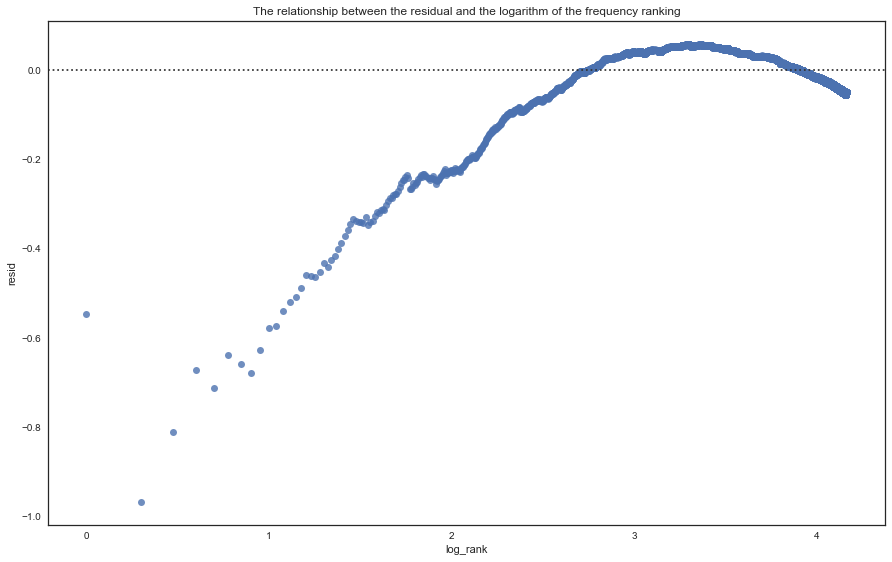

In [8]:
sns.residplot(df.log_rank,df.log_freq)
plt.ylabel('resid')
plt.title('The relationship between the residual and the logarithm of the frequency ranking')

<p style="font-size:16px;font-family:KaiTi;line-height:2;">因此，为了观察不同频次词语的分布规律，我们可以用四分位将频次与排名数据分为四组：前25%的词语为出现次数大于等于296；25%至50%分位的词语的出现次数位于126与296之间；50%分位至75%分位的词语出现次数位于51至126之间；最后25%的词语出现频次小于等于51次，由于原数据中删除了所有出现次数小于等于50次的词语，则最后一部分数据的频次都为51次为一个常数，此一部分的回归没有什么意义，但为了完整性，我们还是将其列出来。我们对这四组数据分别做回归并观察其残差图：</p>

Text(0,0.5,'')

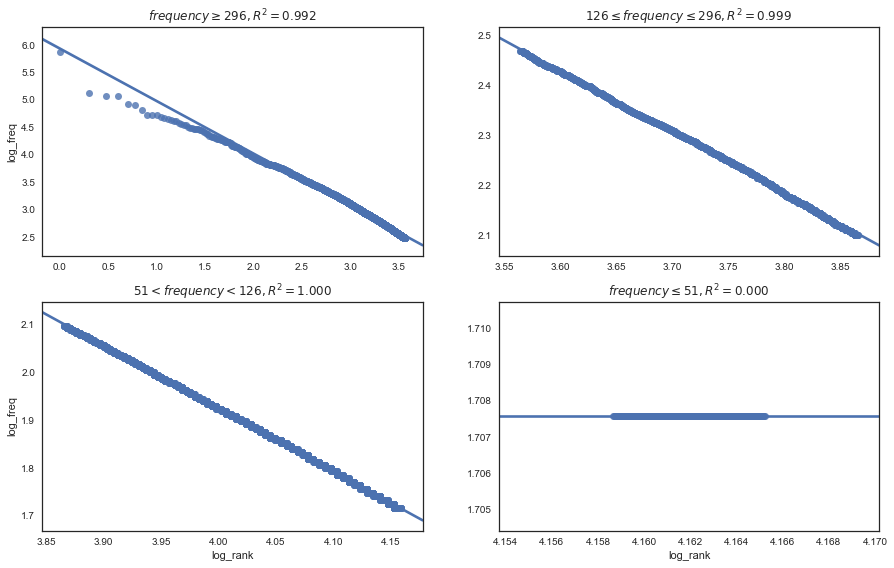

In [9]:
log_rank_first = df.log_rank[df.freq>=296]
log_freq_first = df.log_freq[df.freq>=296]
log_rank_second = df.log_rank[(126<=df.freq) & (df.freq<296)]
log_freq_second = df.log_freq[(126<=df.freq) & (df.freq<296)]
log_rank_third = df.log_rank[(51<df.freq) & (df.freq<126)]
log_freq_third = df.log_freq[(51<df.freq) & (df.freq<126)]
log_rank_fourth = df.log_rank[df.freq<=51]
log_freq_fourth = df.log_freq[df.freq<=51]


plt.subplot(221)
sns.regplot(log_rank_first,log_freq_first)
plt.title('$frequency \geq 296,R^2=0.992$')
plt.xlabel('')
plt.subplot(222)
sns.regplot(log_rank_second,log_freq_second)
plt.title('$126 \leq frequency \leq 296,R^2=0.999$')
plt.xlabel('')
plt.ylabel('')
plt.subplot(223)
sns.regplot(log_rank_third,log_freq_third)
plt.title('$51<frequency<126,R^2=1.000$')
plt.subplot(224)
sns.regplot(log_rank_fourth,log_freq_fourth)
plt.title('$frequency \leq 51,R^2=0.000$')
plt.ylabel('')

Text(0,0.5,'')

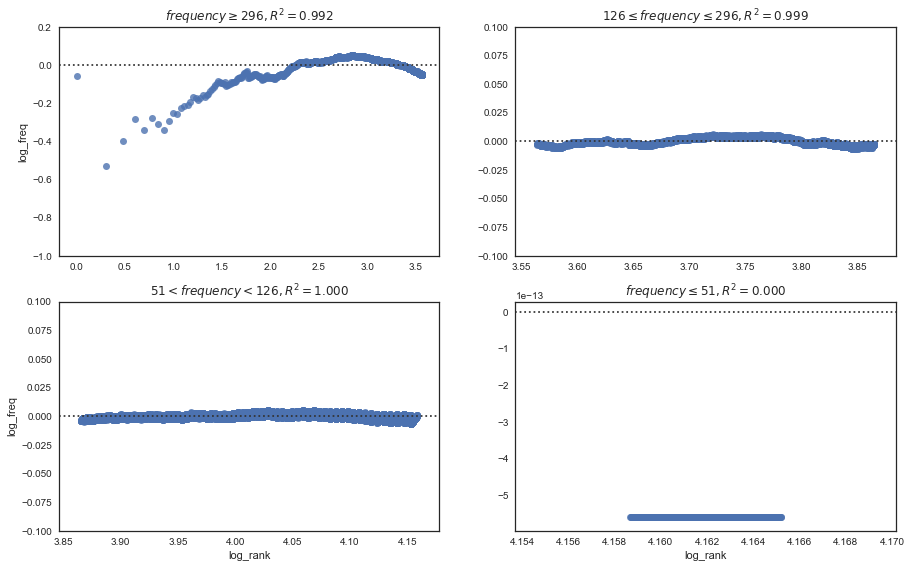

In [10]:
plt.subplot(221)
sns.residplot(log_rank_first,log_freq_first)
plt.title('$frequency \geq 296,R^2=0.992$')
plt.xlabel('')
plt.ylim(-1,0.2)
plt.subplot(222)
sns.residplot(log_rank_second,log_freq_second)
plt.title('$126 \leq frequency \leq 296,R^2=0.999$')
plt.xlabel('')
plt.ylabel('')
plt.ylim(-0.1,0.1)
plt.subplot(223)
sns.residplot(log_rank_third,log_freq_third)
plt.title('$51<frequency<126,R^2=1.000$')
plt.ylim(-0.1,0.1)
plt.subplot(224)
sns.residplot(log_rank_fourth,log_freq_fourth)
plt.title('$frequency \leq 51,R^2=0.000$')
plt.ylabel('')

<p style="font-size:16px;font-family:KaiTi;line-height:2;">我们可以看到对于25%-75%分位的词语，线性回归的拟合情况非常好，$R^2$均接近于一，而前25%的高频词语拟合程度就不太好，$R^2$只有$0.992$，而大部分的回归残差都来自于排名前300名的词语。总之，汉语词频的分布规律基本与齐普夫定律保持一致，而低频词语的一致性程度更高。从回归结果我们可以得到$log(f)=5.71-0.88log(r)$，则频次排名每增加1%，其出现频次要下降0.88%。</p>

<h2 style="font-family:kaiti">三、汉字笔画数分布规律</h2>

<p style="font-size:16px;font-family:KaiTi;line-height:2;">在<a href="https://onlinelibrary.wiley.com/doi/abs/10.1111/j.0039-3193.2004.00109.x">这篇论文</a>里，Bengt Sigurd等人发现英语中词语的长度与其出现频率的关系大致服务<a href="https://en.wikipedia.org/wiki/Gamma_distribution">伽马分布</a>,如下图：</p>,

<img src="https://ws1.sinaimg.cn/large/005LuiSpgy1fv95n53finj30io09n751.jpg">

<p style="font-size:16px;font-family:KaiTi;line-height:2;">尽管在汉语中没有单词长度这种说法，但汉字的笔画数与其有一定相似之处，它们都衡量了人们为了表达特定的含义而愿意付出多少代价。词语的长度不能太短，因为这样能够形成的词语就太少，不能表达足够丰富的含义；词语的长度也不能太长，这样记忆与表达的难度会提升，从而影响沟通的效率。这就使得英语中长度太长或太短的词语出现的频率都比较低，同样的道理对于汉字的笔画数也是适用的。我们可以使用现有数据，来检验一下汉字笔画数的分布规律是否与英语单词长度的分布规律类似，都服从伽马分布。</p>

<p style="font-size:16px;font-family:KaiTi;line-height:2;">首先，让我们导入数据并看一下数据的基本信息：</p>

In [13]:
sc = pd.read_excel('char_stroke_count.xlsx')
sc.head(10)

,rank,char,stroke_count
0,1,的,8
1,2,一,1
2,3,是,9
3,4,不,4
4,5,了,2
5,6,在,6
6,7,人,2
7,8,有,6
8,9,我,7
9,10,他,5


<p style="font-size:16px;font-family:KaiTi;line-height:2;">该表格共收录了10000个汉字，其中第三列为汉字的笔画数，我们可以首先看下汉字笔画数的直方图，从而让我们对汉字笔画数的分布情况有一个直观的理解(如下图)。我们可以看到，笔画数为10，11与12的汉字较多，频率均处于9%-10%之间。如果笔画数小于11，则随着笔画数下降，出现的频率逐渐降低；反之，笔画数大于11，则随着笔画数上升，出现的频率逐渐降低。</p>

Text(0.5,1,'Histogram of the number of strokes in Chinese characters')

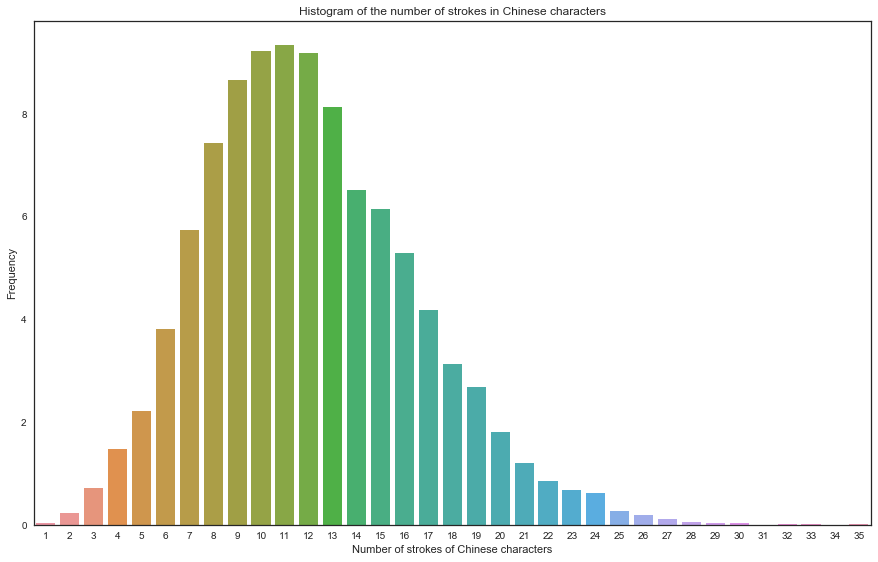

In [15]:
count_pert = []
for i in range(1,36):
    count_pert.append(len(sc.stroke_count[sc.stroke_count==i])/100.)

x = np.arange(1,36)
sns.barplot(x,count_pert)
plt.xlabel('Number of strokes of Chinese characters')
plt.ylabel('Frequency')
plt.title('Histogram of the number of strokes in Chinese characters')

<p style="font-size:16px;font-family:KaiTi;line-height:2;">接下来让我们比较汉字笔画数的实际分布与伽马分布与正态分布的相似程度(如下图)，我们可以发现，实际分布与伽马分布非常接近，而与正态分布相距较远。通过绘制quantiles-quantiles图，我们可以更加直观的观察到这一点：</p>

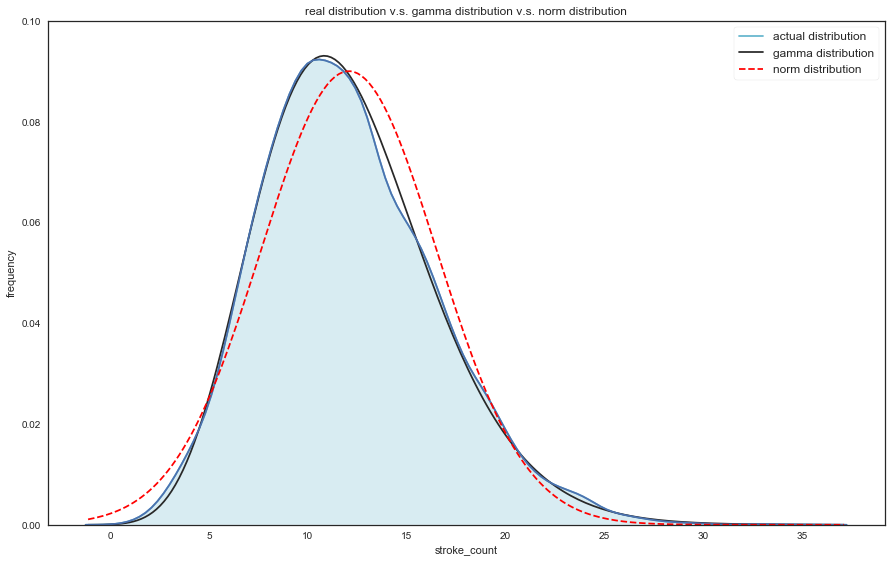

In [16]:
from scipy.stats import norm,gamma,probplot
sns.distplot(sc.stroke_count,hist=False,kde_kws={"shade": True,"label":"actual distribution"},
             fit=gamma,fit_kws={"label":"gamma distribution"},color='c')
sns.distplot(sc.stroke_count,hist=False,fit=norm,
             fit_kws={"label":"norm distribution","color":"red","linestyle":"--"})
plt.ylabel('frequency')
plt.title('real distribution v.s. gamma distribution v.s. norm distribution')
plt.ylim(0,0.1)
plt.legend(frameon=True,fontsize=12)

Text(0.5,1,'actual distribution v.s. norm distribution')

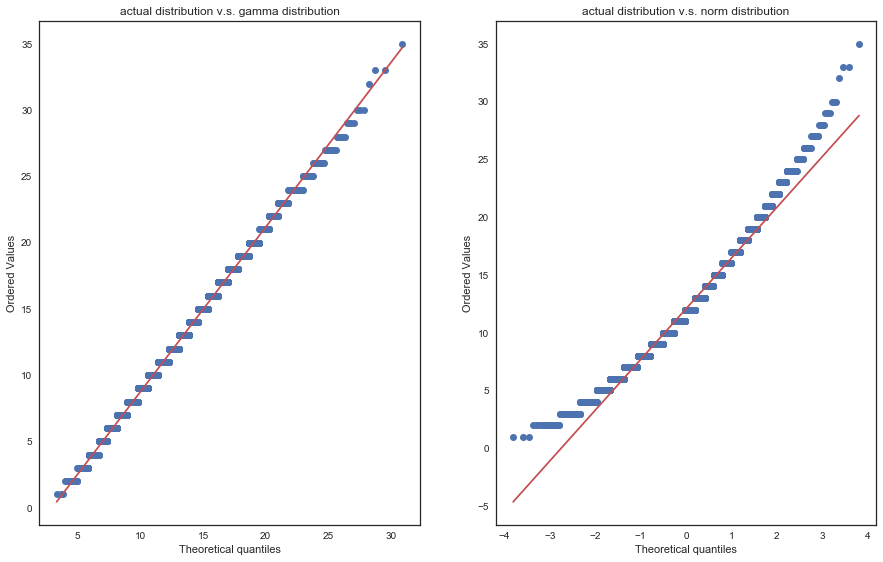

In [17]:
plt.subplot(121)
probplot(sc.stroke_count,plot=plt,dist='gamma',sparams=(12.68,),fit=True)
plt.title('actual distribution v.s. gamma distribution')
plt.subplot(122)
probplot(sc.stroke_count,plot=plt,dist='norm',fit=True)
plt.title('actual distribution v.s. norm distribution')

<h2 style="font-family:kaiti">四、结论</h2>

<p style="font-size:16px;font-family:KaiTi;line-height:2;">有趣的是，虽然英语与汉语之间存在着天壤之别，它们的分布规律却有着很大的相似性。至于为什么会出现这种分布规律，现在还没有一个统一的解释。对于齐普夫定律的成因，目前至少有三种解释：第一种是齐普夫本人的解释，他认为这体现了人思维的经济性，即人类在不影响沟通效率的情况下尽可能的减少记忆词语的负担，这导致了某些常用词汇出现的频率非常高，已经完全足以应付日常生活中的大多数沟通场景。第二种观点认为齐普夫定律是“强者愈强、弱者愈强”这一规律的结果，某些常用词汇会被使用的越来越多，最终会导致类似于幂律分布的情况，其表现形式便是齐普夫定律。第三种观点：很多学者发现，齐普夫定律不仅在语言领域存在，而且在某些与语言并无关系的领域，如城市人口数排名与其人口的关系也服从齐普夫定律。这使得学者们倾向于相信，齐普夫定律的真正原因恐怕与语言的性质关系不大，而是与某种数据生成的过程有关。如Xavier在他的论文<a href="https://academic.oup.com/qje/article-abstract/114/3/739/1848099">Zipf's Law for Cities: An Explanation</a>中给出了一种简单而又美妙的答案：不需要任何条件，只要所有城市人口都以一个同分布的随机速度增长，那么最后的城市人口就会符合Zipf法则。这个简单的条件也是Zipf分布横跨语言、经济、地理数界的原因之一。</p>

<h2 style="font-family:kaiti">五、参考</h2>

<div style="font-size:16px;font-family:Georgia;line-height:2;">

<ol>
<li><a href='https://en.wikipedia.org/wiki/Zipf%27s_law'>zip定律英文维基</a></li>
<li><a href='http://lingua.mtsu.edu/chinese-computing/statistics/char/list.php?Which=MO'>现代汉语单字频率列表</a></li>
<li><a href='http://corpus.zhonghuayuwen.org/index.aspx'>中文语料库</a></li>
<li><a href='https://plus.maths.org/content/mystery-zipf'>The mystery of Zipf</a></li>
<li>Gabaix, X. (1999). Zipf’s law for cities: an explanation. <em>The Quarterly journal of economics</em>, <em>114</em>(3), 739–767.</li>
<li>Newman, M. E. (2005). Power laws, Pareto distributions and Zipf’s law. <em>Contemporary physics</em>, <em>46</em>(5), 323–351.</li>
<li>Shtrikman, S. (1994). Some comments on Zipf’s law for the Chinese language. <em>Journal of Information Science</em>, <em>20</em>(2), 142–143.</li>
<li>Li, W. (1992). Random texts exhibit Zipf’s-law-like word frequency distribution. <em>IEEE Transactions on information theory</em>, <em>38</em>(6), 1842–1845.</li>

</ol>

</div>